# Machine Learning

## ARIMA

### Jorge de Toro, Juan A. Ortíz

### Predicción series temporales by month

# ARIMA

In [1]:
# pip install pmdarima
import pandas as pd
import numpy as np
import datetime

import csv

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#dependencias para desarrollar ARIMA Forecasting Models

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import adfuller

import pmdarima as pm
import statsmodels.api as sm

from pandas.plotting import autocorrelation_plot

from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('C:/Users/jorge/El Corte Inglés, S.A/Otb y el master - Documentos/VentaMes2017-2019.csv',';',parse_dates=True)

df['Fecha Venta'] = pd.to_datetime(df['Fecha Venta'],format='%Y/%m/%d')
df=df.dropna()

#set date as index column. (required in time series)
df = df.set_index('Fecha Venta')
df = df.asfreq('MS')
print('Shape of data',df.shape)
print(df.dtypes)
df.head()

Shape of data (36, 1)
Unidades Vendidas    int64
dtype: object


,Unidades Vendidas
Fecha Venta,
2017-01-01,94158
2017-02-01,30152
2017-03-01,38901
2017-04-01,58229
2017-05-01,59880


In [4]:
# Paso para verificar que un índice temporal está completo

(df.index == pd.date_range(start=df.index.min(),
                              end=df.index.max(),
                              freq=df.index.freq)).all()

True

<AxesSubplot:xlabel='Fecha Venta'>

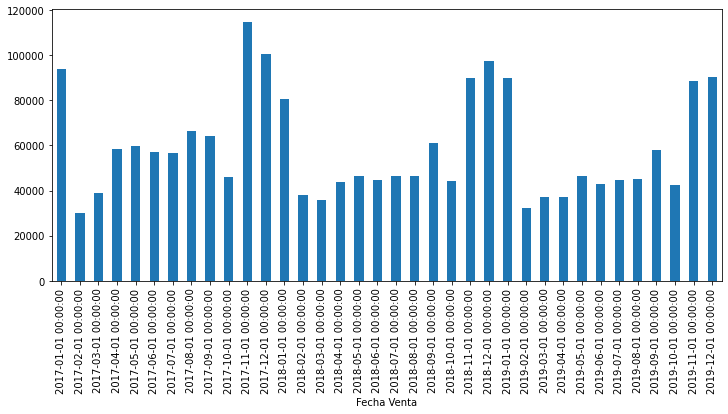

In [5]:
df['Unidades Vendidas'].plot(figsize=(12,5),kind='bar')

#### Chequeamos la estacionalidad

In [6]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF Statistic : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [7]:
adf_test(df['Unidades Vendidas'])

#p-value < 0.05 estacionaria
#p-value > 0.05 no es estacionaria

1. ADF Statistic :  -4.8718801184069935
2. P-Value :  3.9546700444868994e-05
3. Num Of Lags :  8
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 27
5. Critical Values :
	 1% :  -3.6996079738860943
	 5% :  -2.9764303469999494
	 10% :  -2.627601001371742


#### Resolvemos el orden de modelo ARIMA

In [8]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [9]:
stepwise_fit = auto_arima(df['Unidades Vendidas'],seasonal=True, m=12)
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   36
Model:             SARIMAX(3, 0, 3)x(1, 0, [1], 12)   Log Likelihood                -392.678
Date:                              Wed, 23 Jun 2021   AIC                            805.356
Time:                                      16:17:32   BIC                            821.191
Sample:                                           0   HQIC                           810.883
                                               - 36                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   9.056e+04   2.29e+05      0.396      0.692   -3.58e+05    5.39e+05
ar.L1         -1.7337      3.720     -0.466      0.641      -9.024       5.557
ar.L2         -1.4894      2.997     -0.497      0.619      -7.364       4.385
ar.L3         -0.7358      2.768     -0.266      0.790      -6.162       4.690
ma.L1          1.9918      3.914      0.509      0.611      -5.679       9.663
ma.L2          1.9666      4.280      0.460      0.646      -6.422      10.355
ma.L3          0.9532      3.874      0.246      0.806      -6.640       8.546
ar.S.L12       0.7034      0.357      1.970      0.049       0.004       1.403
ma.S.L12       0.1563      0.922      0.170      0.865      -1.651       1.964
sigma2      2.014e+08     77.354    2.6e+06      0.000    2.01e+08    2.01e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 6.24
Prob(Q):                              0.82   Prob(JB):                         0.04
Heteroskedasticity (H):               0.29   Skew:                             0.81
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.28e+22. Standard errors may be unstable.
"""

#### Vemos que nuestro modelo tiene orden (3, 0, 3)x(1, 0, [1], 12)

In [10]:
from statsmodels.tsa.arima_model import ARIMA

(36, 1)


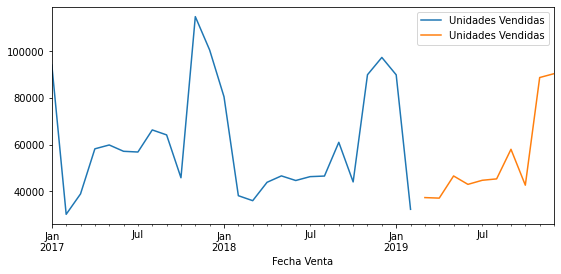

In [11]:
print(df.shape)
train=df.iloc[:-10]
test=df.iloc[-10:]
#print(train.shape,test.shape)
#print(test.iloc[0],test.iloc[-1])

fig, ax=plt.subplots(figsize=(9, 4))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
ax.legend();

## Entrenamos el modelo

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(train['Unidades Vendidas'],order=(3, 0, 3), seasonal_order=(1, 0, [1], 12))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                    Unidades Vendidas   No. Observations:                   26
Model:             SARIMAX(3, 0, 3)x(1, 0, [1], 12)   Log Likelihood                -291.642
Date:                              Wed, 23 Jun 2021   AIC                            601.283
Time:                                      16:17:32   BIC                            612.606
Sample:                                  01-01-2017   HQIC                           604.544
                                       - 02-01-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3206      0.841      0.381      0.703      -1.327       1.968
ar.L2         -0.0781      1.818     -0.043      0.966      -3.640       3.484
ar.L3          0.7285      1.859      0.392      0.695      -2.915       4.372
ma.L1          0.1001      1.087      0.092      0.927      -2.030       2.230
ma.L2          0.0989      1.589      0.062      0.950      -3.016       3.214
ma.L3         -0.8365      1.135     -0.737      0.461      -3.062       1.389
ar.S.L12       0.7894      2.285      0.345      0.730      -3.689       5.268
ma.S.L12      -0.1540      5.136     -0.030      0.976     -10.220       9.912
sigma2      3.506e+08   3.53e-09   9.92e+16      0.000    3.51e+08    3.51e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 1.85
Prob(Q):                              0.76   Prob(JB):                         0.40
Heteroskedasticity (H):               0.34   Skew:                             0.43
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.38e+34. Standard errors may be unstable.
"""

#### Hacemos las predicciones sobre el conjunto test

<AxesSubplot:xlabel='Fecha Venta'>

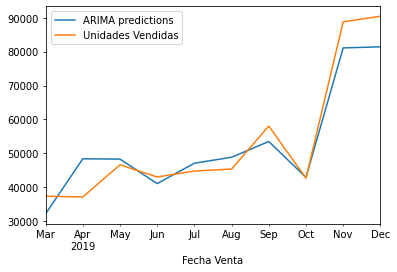

In [13]:
start=len(train)
end=len(train)+len(test)-1
#index_future_dates=pd.date_range(start='2017-01-01',end='2019-12-01')
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
#pred.index=index_future_dates
pred.plot(legend=True)
test['Unidades Vendidas'].plot(legend=True)

<AxesSubplot:xlabel='Fecha Venta'>

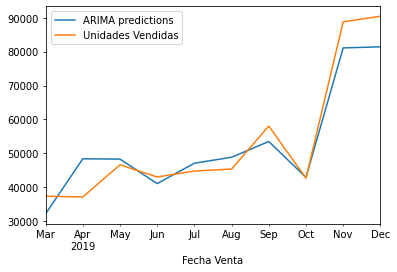

In [14]:
pred.plot(legend='ARIMA Predictions')
test['Unidades Vendidas'].plot(legend=True)

In [15]:
test['Unidades Vendidas'].mean()

53400.1

In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred,test['Unidades Vendidas']))
print(rmse)

5829.452602043905


#### Para datos futuros

In [17]:
model2=ARIMA(df['Unidades Vendidas'],order=(3,0,3))
model2=model2.fit()
df.tail(12)

,Unidades Vendidas
Fecha Venta,
2019-01-01,89955
2019-02-01,32295
2019-03-01,37323
2019-04-01,37094
2019-05-01,46596
2019-06-01,42994
2019-07-01,44742
2019-08-01,45341
2019-09-01,58027


In [18]:
index_future_months = pd.date_range(start='2020-01-01', periods=5, freq='M')
pred = model2.predict(start=len(df),end=len(df)+4,typ='levels').rename('ARIMA Predictions')
pred.index = index_future_months
print(pred)

2020-01-31    95956.511376
2020-02-29    48760.664482
2020-03-31    55473.019597
2020-04-30    60067.201389
2020-05-31    57839.458917
Freq: M, Name: ARIMA Predictions, dtype: float64


<AxesSubplot:>

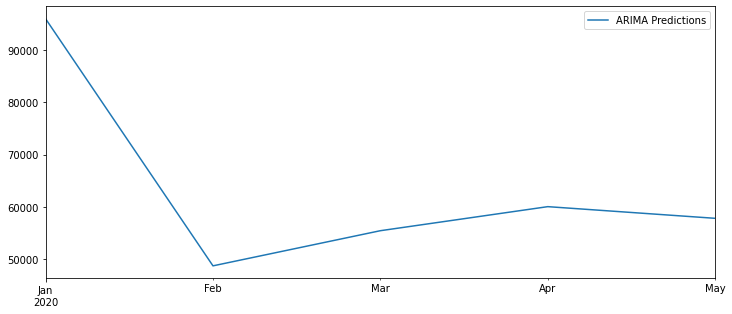

In [19]:
pred.plot(figsize=(12,5),legend=True)

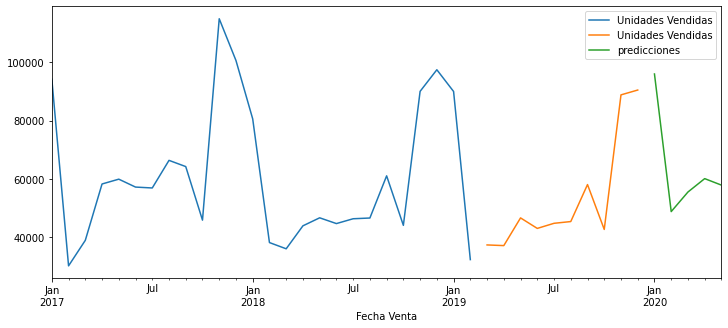

In [20]:
fig, ax = plt.subplots(figsize=(12, 5))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
pred.plot(ax=ax, label='predicciones')
ax.legend();

## Predicción series temporales by date

Realizamos el experimento con datos diarios de los años 2017,2018 y 2019.

In [3]:
# pip install pmdarima
import pandas as pd
import numpy as np
import datetime

import csv

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#dependencias para desarrollar ARIMA Forecasting Models

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import statsmodels.api as sm

from pandas.plotting import autocorrelation_plot

from sklearn.metrics import mean_squared_error


In [5]:
df_diario = pd.read_csv('C:/Users/jorge/El Corte Inglés, S.A/Otb y el master - Documentos/VentaDia 2017-2019.csv',';',parse_dates=True)

df_diario['Fecha Venta'] = pd.to_datetime(df_diario['Fecha Venta'])
df_diario=df_diario.dropna()

#set date as index column. (required in time series)
df_diario = df_diario.set_index('Fecha Venta')

print('Shape of data',df_diario.shape)
print(df_diario.dtypes)
print(df_diario.head())
print(df_diario.tail())

Shape of data (1095, 1)
Unidades Vendidas    int64
dtype: object
             Unidades Vendidas
Fecha Venta                   
2017-01-01                 243
2017-01-02                9907
2017-01-03                9800
2017-01-04                8922
2017-01-05                4312
             Unidades Vendidas
Fecha Venta                   
2019-12-27                4176
2019-12-28                4522
2019-12-29                3401
2019-12-30                5104
2019-12-31                2439


In [6]:
 #Paso para verificar que un índice temporal está completo

(df_diario.index == pd.date_range(start=df_diario.index.min(),
                              end=df_diario.index.max(),
                              freq=df_diario.index.freq)).all()

True

<AxesSubplot:xlabel='Fecha Venta'>

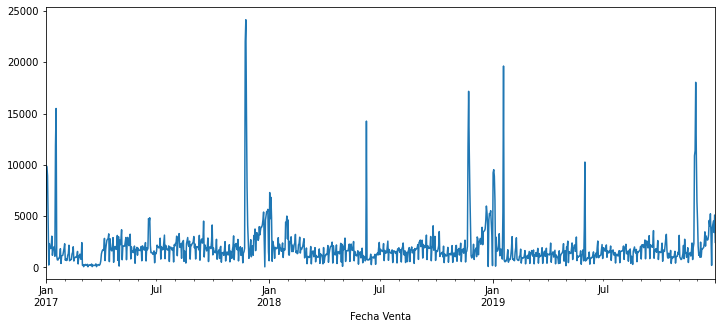

In [7]:
df_diario['Unidades Vendidas'].plot(figsize=(12,5))

In [10]:
# chequeamos la estacionalidad
# --------------------------------------------------------------------------------------------------------------

from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  df_diariotest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF Statistic : ",df_diariotest[0])
  print("2. P-Value : ", df_diariotest[1])
  print("3. Num Of Lags : ", df_diariotest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", df_diariotest[3])
  print("5. Critical Values :")
  for key, val in df_diariotest[4].items():
      print("\t",key, ": ", val)

# --------------------------------------------------------------------------------------------------------------

In [11]:
adf_test(df_diario['Unidades Vendidas'])

#p-value < 0.05 estacionaria
#p-value > 0.05 no es estacionaria

1. ADF Statistic :  -4.775710243738713
2. P-Value :  6.051339939311522e-05
3. Num Of Lags :  22
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1072
5. Critical Values :
	 1% :  -3.4364647646486093
	 5% :  -2.864239892228526
	 10% :  -2.5682075189699822


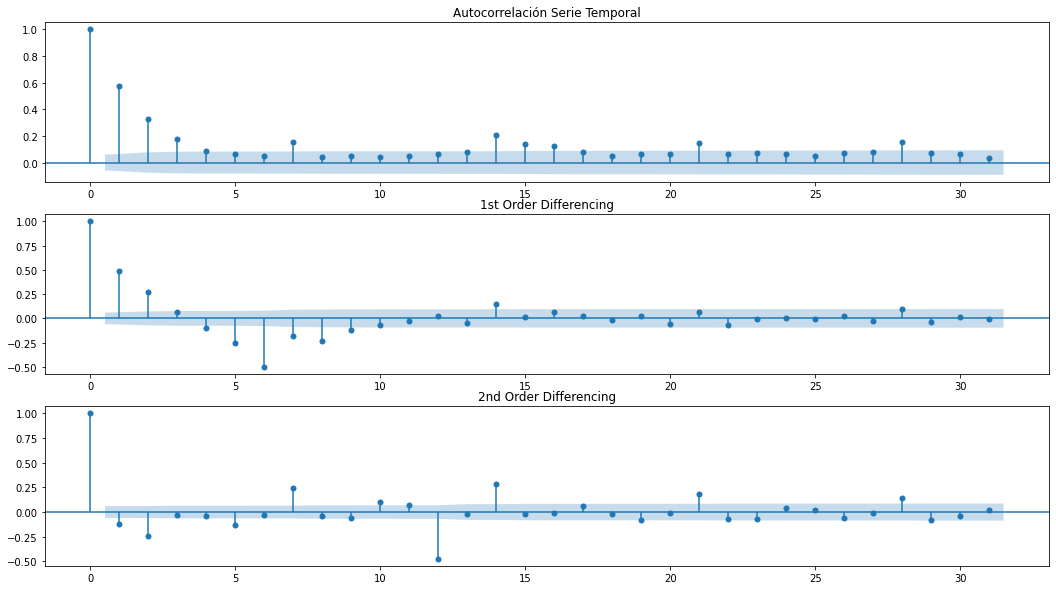

In [12]:
fig = plt.figure(figsize=(18,10))

#serie original
ax1 = fig.add_subplot(311)
fig = plot_acf(df_diario['Unidades Vendidas'], ax=ax1, title="Autocorrelación Serie Temporal")

#1st differencing
ax2 = fig.add_subplot(312)
fig = plot_acf(df_diario['Unidades Vendidas'].diff(6).dropna(), ax=ax2, title="1st Order Differencing")

#2nd Differencing
ax3 = fig.add_subplot(313)
fig = plot_acf(df_diario['Unidades Vendidas'].diff().diff(12).dropna(), ax=ax3, title="2nd Order Differencing")

Resolvemos el orden del modelo ARIMA

In [13]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [14]:
stepwise_fit = auto_arima(df_diario['Unidades Vendidas'],seasonal=True,
                          suppress_warnings=True)           

stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1095
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -9651.610
Date:                Thu, 24 Jun 2021   AIC                          19309.221
Time:                        17:16:17   BIC                          19324.216
Sample:                             0   HQIC                         19314.895
                               - 1095                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    813.1306     88.463      9.192      0.000     639.746     986.516
ar.L1          0.5780      0.009     66.998      0.000       0.561       0.595
sigma2      2.651e+06   3.19e+04     83.112      0.000    2.59e+06    2.71e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             93184.02
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             4.14
Prob(H) (two-sided):                  0.18   Kurtosis:                        47.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Vemos que nuestro modelo tiene orden (1,0,0)

In [15]:
from statsmodels.tsa.arima_model import ARIMA

In [16]:
#creamos conjunto de entrenamiento y test

print(df_diario.shape)
train=df_diario.iloc[:-30]
test=df_diario.iloc[-30:]
print(train.shape,test.shape)
print(test.iloc[0],test.iloc[-1])

(1095, 1)
(1065, 1) (30, 1)
Unidades Vendidas    4536
Name: 2019-12-02 00:00:00, dtype: int64 Unidades Vendidas    2439
Name: 2019-12-31 00:00:00, dtype: int64


#### Entrenamos el modelo

In [17]:
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(train['Unidades Vendidas'],order=(1,0,0))
model=model.fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:      Unidades Vendidas   No. Observations:                 1065
Model:                     ARMA(1, 0)   Log Likelihood               -9393.896
Method:                       css-mle   S.D. of innovations           1638.324
Date:                Thu, 24 Jun 2021   AIC                          18793.792
Time:                        17:16:24   BIC                          18808.704
Sample:                    01-01-2017   HQIC                         18799.442
                         - 12-01-2019                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1904.8660    119.085     15.996      0.000    1671.464    2138.268
ar.L1.Unidades Vendidas     0.5790      0.025     23.112      0.000       0.530       0.628
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7272           +0.0000j            1.7272            0.0000
-----------------------------------------------------------------------------
"""

#### Hacemos las predicciones sobre el conjunto test

<AxesSubplot:xlabel='Fecha Venta'>

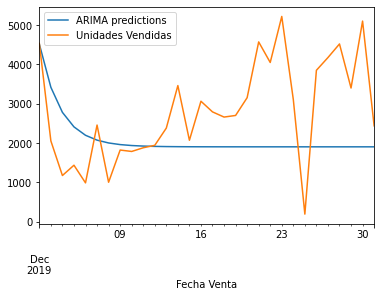

In [18]:
start=len(train)
end=len(train)+len(test)-1
#index_future_dates=pd.date_range(start='2018-01-01',end='2020-12-31')
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
#pred.index=index_future_dates
pred.plot(legend=True)
test['Unidades Vendidas'].plot(legend=True)

<AxesSubplot:xlabel='Fecha Venta'>

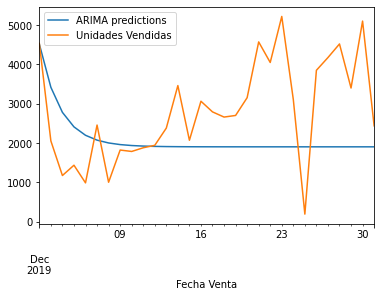

In [19]:
pred.plot(legend='ARIMA Predictions')
test['Unidades Vendidas'].plot(legend=True)

In [20]:
test['Unidades Vendidas'].mean()

2800.866666666667

In [21]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred,test['Unidades Vendidas']))
print(rmse)

1541.5217208217364


In [22]:
model2=ARIMA(df_diario['Unidades Vendidas'],order=(3,1,5))
model2=model2.fit()
df_diario.tail()

,Unidades Vendidas
Fecha Venta,
2019-12-27,4176
2019-12-28,4522
2019-12-29,3401
2019-12-30,5104
2019-12-31,2439


#### Para datos futuros

In [23]:
index_future_dates=pd.date_range(start='2020-01-01',end='2020-01-31')
#print(index_future_dates)
pred=model2.predict(start=len(df_diario),end=len(df_diario)+30,typ='levels').rename('ARIMA Predictions')
#print(comp_pred)
pred.index=index_future_dates
print(pred)

2020-01-01    2555.246364
2020-01-02    2788.373407
2020-01-03    2644.937691
2020-01-04    3184.873219
2020-01-05    2561.273982
2020-01-06    3238.089465
2020-01-07    2682.736063
2020-01-08    3030.096893
2020-01-09    2966.030800
2020-01-10    2743.487344
2020-01-11    3209.650846
2020-01-12    2596.414347
2020-01-13    3238.080700
2020-01-14    2695.534587
2020-01-15    3036.777613
2020-01-16    2963.037558
2020-01-17    2760.314436
2020-01-18    3198.893882
2020-01-19    2614.828761
2020-01-20    3231.114390
2020-01-21    2705.120912
2020-01-22    3041.691479
2020-01-23    2959.948401
2020-01-24    2776.181032
2020-01-25    3188.667518
2020-01-26    2632.665390
2020-01-27    3224.402879
2020-01-28    2714.706185
2020-01-29    3046.304103
2020-01-30    2957.377540
2020-01-31    2791.405499
Freq: D, Name: ARIMA Predictions, dtype: float64


<AxesSubplot:>

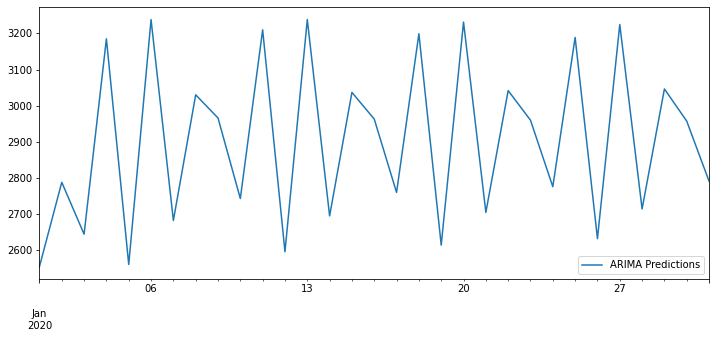

In [24]:
pred.plot(figsize=(12,5),legend=True)